# C. elegans Cell Division Data Analysis

This notebook demonstrates comprehensive analysis of C. elegans cell division data using the DevoTG framework.

## Overview
- Load and validate cell division dataset
- Perform statistical analysis
- Calculate thresholds for visualization
- Generate summary reports and plots

In [2]:
# Import required libraries
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Add parent directory to path to import custom modules
sys.path.append(str(Path.cwd().parent))

# Import DevoTG modules
from devotg.data import DatasetLoader
from devotg.utils import ThresholdCalculator
from devotg.analysis import StatisticalAnalyzer, generate_comprehensive_report

# Set up plotting
plt.style.use('default')
sns.set_palette("husl")
%matplotlib inline

print("DevoTG Data Analysis Notebook")
print("=============================")

DevoTG Data Analysis Notebook


## 1. Dataset Loading and Validation

In [3]:
# Load the dataset
csv_path = '../data/cell_lineage_datasets/cells_birth_and_pos.csv'

# Initialize loader
loader = DatasetLoader(default_csv_path=csv_path)

# Load and validate data
try:
    df = loader.load_csv()
    is_valid = loader.validate_dataset(df)
    
    if is_valid:
        print("\n✅ Dataset loaded and validated successfully!")
    else:
        print("\n⚠️  Dataset loaded but validation issues found.")
        
except Exception as e:
    print(f"❌ Error loading dataset: {e}")
    # Load sample data for demonstration
    from devotg.data.dataset_loader import load_sample_data
    df = load_sample_data()
    print("\n📊 Using sample data for demonstration")

Loaded dataset: 642 rows, 7 columns

✅ Dataset loaded and validated successfully!


In [4]:
# Display basic dataset information
loader.print_dataset_info(df)

DATASET INFORMATION

Basic Info:
  Shape: 642 rows × 7 columns
  Memory usage: 0.12 MB

Columns:
   1. Parent Cell (object)
   2. parent_x (float64)
   3. parent_y (float64)
   4. parent_z (float64)
   5. Daughter 1 (object)
   6. Daughter 2 (object)
   7. Birth Time (int64)

Missing Values:
  No missing values found

Cell Division Statistics:
  Unique parent cells: 629
  Total divisions: 642
  Most active parent cells:
    ABplapapaa: 2 divisions
    MSaaaaaa: 2 divisions
    MSaaaapa: 2 divisions
    MSaaaapp: 2 divisions
    MSaaapaa: 2 divisions

Temporal Statistics:
  Time range: 0.0 - 735.0
  Time span: 735.0
  Unique time points: 121

Spatial Statistics:
  parent_x: 0.0 to 603.3 (range: 603.3)
  parent_y: 0.0 to 394.9 (range: 394.9)
  parent_z: 0.0 to 24.3 (range: 24.3)


## 2. Dataset Overview and Basic Statistics

In [5]:
print("--- Dataset Info ---")
df.info()

print("\n--- First 5 Rows ---")
display(df.head())

print("\n--- Basic Statistics ---")
display(df.describe())

print("\n--- Missing Values ---")
missing_values = df.isnull().sum()
if missing_values.sum() == 0:
    print("No missing values found.")
else:
    display(missing_values[missing_values > 0])

--- Dataset Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 642 entries, 0 to 641
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Parent Cell  642 non-null    object 
 1   parent_x     642 non-null    float64
 2   parent_y     642 non-null    float64
 3   parent_z     642 non-null    float64
 4   Daughter 1   642 non-null    object 
 5   Daughter 2   642 non-null    object 
 6   Birth Time   642 non-null    int64  
dtypes: float64(3), int64(1), object(3)
memory usage: 35.2+ KB

--- First 5 Rows ---


,Parent Cell,parent_x,parent_y,parent_z,Daughter 1,Daughter 2,Birth Time
0,P0,422.077778,248.316667,14.326667,AB,P1,0
1,AB,317.785054,251.800426,14.700365,ABa,ABp,17
2,P1,445.339357,253.860563,15.238196,EMS,P2,18
3,ABa,251.150370,254.408362,15.063837,ABar,ABal,35
4,ABp,358.984127,267.276513,14.877588,ABpr,ABpl,35



--- Basic Statistics ---


,parent_x,parent_y,parent_z,Birth Time
count,642.000000,642.000000,642.000000,642.000000
mean,329.759148,248.656641,14.700047,247.073209
std,100.589150,44.479527,2.463746,90.753730
min,0.000000,0.000000,0.000000,0.000000
25%,260.919426,238.676682,14.684133,180.000000
50%,324.135535,254.402565,14.989028,245.000000
75%,404.640476,268.365505,15.425016,302.250000
max,603.258611,394.864865,24.289960,735.000000



--- Missing Values ---
No missing values found.


In [6]:
print("--- Unique Values for Key Columns ---")
key_columns = ['Parent Cell', 'Daughter 1', 'Daughter 2']
for col in key_columns:
    if col in df.columns:
        print(f"{col}: {df[col].nunique()} unique values")

# Count of unique parent cells
print(f"\nNumber of unique parent cells: {df['Parent Cell'].nunique()}")

# Count of unique daughter cells
all_daughter_cells = pd.concat([df['Daughter 1'], df['Daughter 2']]).dropna().unique()
print(f"Number of unique daughter cells: {len(all_daughter_cells)}")

--- Unique Values for Key Columns ---
Parent Cell: 629 unique values
Daughter 1: 575 unique values
Daughter 2: 573 unique values

Number of unique parent cells: 629
Number of unique daughter cells: 1141


In [7]:
# Analyze parent-daughter relationships
parent_counts = df['Parent Cell'].value_counts()
print("Top 10 most frequent parent cells:")
display(parent_counts.head(10))

# Count how many times a cell appears as a daughter
daughter1_counts = df['Daughter 1'].value_counts()
daughter2_counts = df['Daughter 2'].value_counts()
total_daughter_counts = daughter1_counts.add(daughter2_counts, fill_value=0)
print("\nTop 10 most frequent daughter cells:")
display(total_daughter_counts.sort_values(ascending=False).head(10))

# Check for cells that are both parents and daughters
cells_both_roles = parent_counts.index.intersection(total_daughter_counts.index)
print(f"\nNumber of cells that are both parents and daughters: {len(cells_both_roles)}")
print("Example cells that are both parents and daughters:", list(cells_both_roles)[:10])

Top 10 most frequent parent cells:


Parent Cell
ABplapapaa    2
MSaaaaaa      2
MSaaaapa      2
MSaaaapp      2
MSaaapaa      2
MSaaaaap      2
ABalpaa       2
MSaapaaa      2
ABprpppppa    2
MSaapaap      2
Name: count, dtype: int64


Top 10 most frequent daughter cells:


mu bod       82.0
hyp7         23.0
hyp6          6.0
hyp4          3.0
QL            2.0
m7D           2.0
m7VL          2.0
MSaaaappa     2.0
m8            2.0
V5L           2.0
Name: count, dtype: float64


Number of cells that are both parents and daughters: 567
Example cells that are both parents and daughters: ['ABplapapaa', 'MSaaaaaa', 'MSaaaapa', 'MSaaaapp', 'MSaaapaa', 'MSaaaaap', 'ABalpaa', 'MSaapaaa', 'ABprpppppa', 'MSaapaap']


## 3. Comprehensive Statistical Analysis

In [8]:
# Initialize statistical analyzer
analyzer = StatisticalAnalyzer(df)

# Run all analyses
results = analyzer.run_all_analyses()

# Print summary
print(analyzer.get_summary())

Running comprehensive statistical analysis...
✓ Basic Statistics completed
✓ Temporal Analysis completed
✓ Spatial Analysis completed
✓ Lineage Analysis completed
✓ Correlation Analysis completed
STATISTICAL ANALYSIS SUMMARY
Dataset: 642 rows × 7 columns
Memory usage: 0.12 MB

Basic Statistics:
  ✓ Analysis completed successfully

Temporal Analysis:
  ✓ Analysis completed successfully

Spatial Analysis:
  ✓ Analysis completed successfully

Lineage Analysis:
  ✓ Analysis completed successfully

Correlation Analysis:
  ✓ Analysis completed successfully



In [9]:
# Save detailed analysis results
output_dir = Path('../outputs/lineage_analysis/statistics')
output_dir.mkdir(parents=True, exist_ok=True)

analyzer.save_results(output_dir / 'detailed_analysis_results.json')
print(f"Detailed results saved to: {output_dir / 'detailed_analysis_results.json'}")

Analysis results saved to: ../outputs/lineage_analysis/statistics/detailed_analysis_results.json
Detailed results saved to: ../outputs/lineage_analysis/statistics/detailed_analysis_results.json


## 4. Data Visualization - Basic Distributions

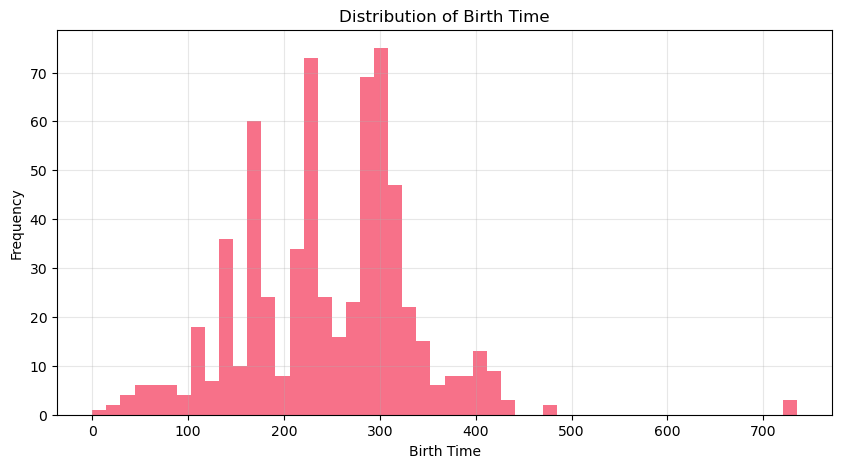

In [10]:
# Distribution of Birth Time
plt.figure(figsize=(10, 5))
df['Birth Time'].hist(bins=50)
plt.title('Distribution of Birth Time')
plt.xlabel('Birth Time')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.show()

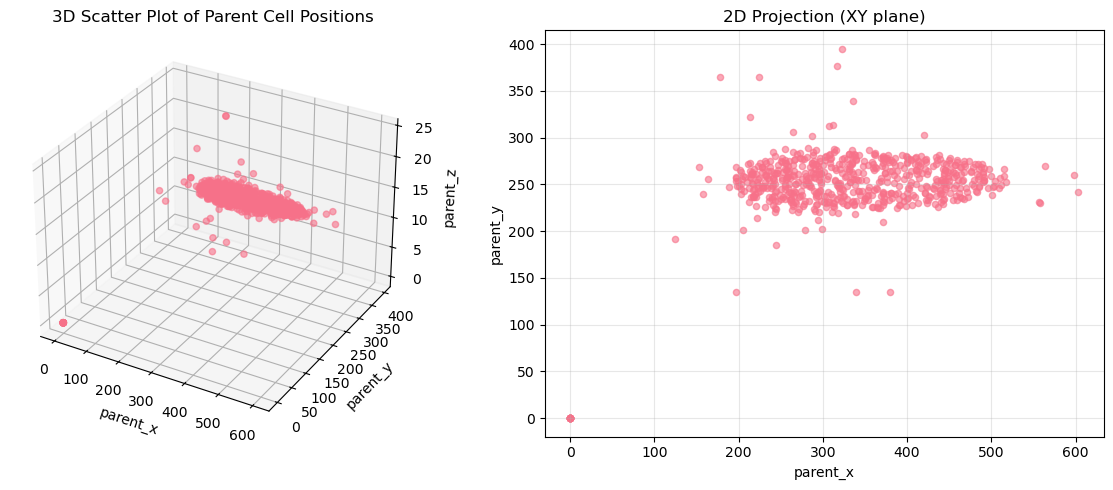

In [11]:
# Scatter plot of parent cell positions (3D projection)
if all(col in df.columns for col in ['parent_x', 'parent_y', 'parent_z']):
    fig = plt.figure(figsize=(12, 5))
    
    # 3D scatter plot
    ax1 = fig.add_subplot(121, projection='3d')
    ax1.scatter(df['parent_x'], df['parent_y'], df['parent_z'], alpha=0.6, s=20)
    ax1.set_title('3D Scatter Plot of Parent Cell Positions')
    ax1.set_xlabel('parent_x')
    ax1.set_ylabel('parent_y')
    ax1.set_zlabel('parent_z')
    
    # 2D projection (XY plane)
    ax2 = fig.add_subplot(122)
    ax2.scatter(df['parent_x'], df['parent_y'], alpha=0.6, s=20)
    ax2.set_title('2D Projection (XY plane)')
    ax2.set_xlabel('parent_x')
    ax2.set_ylabel('parent_y')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

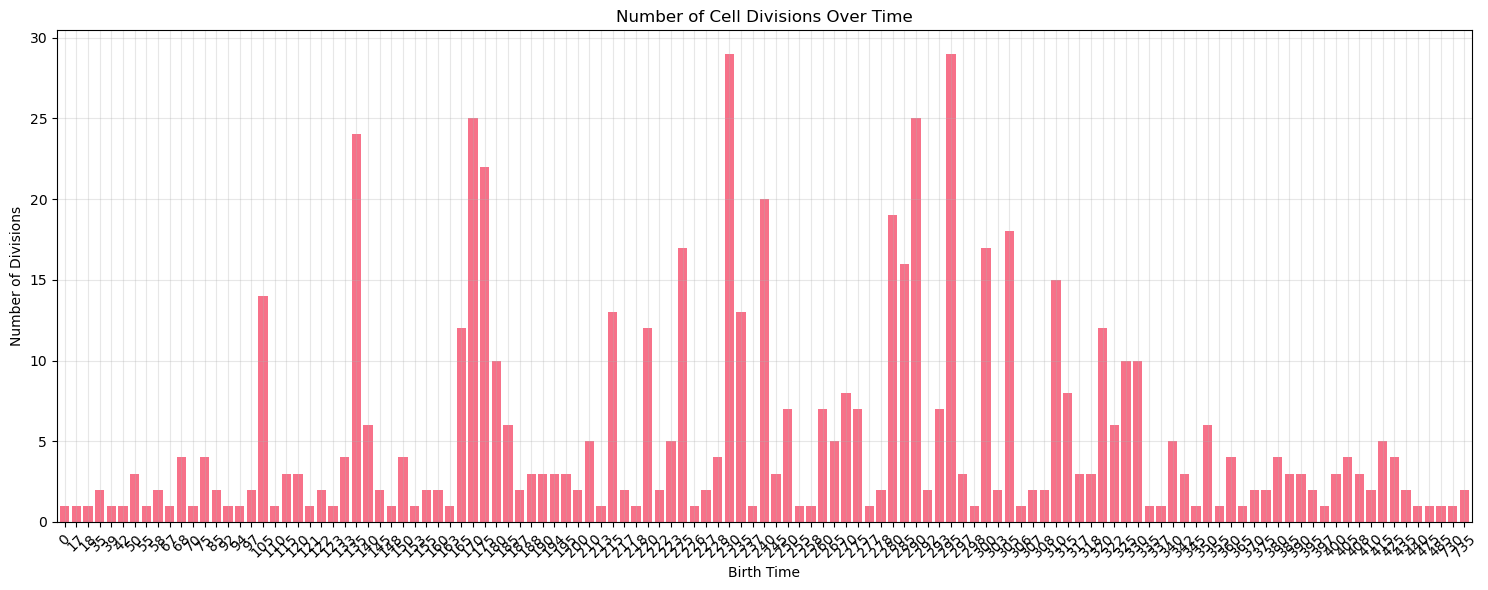

In [12]:
# Number of divisions per birth time
divisions_per_time = df['Birth Time'].value_counts().sort_index()
plt.figure(figsize=(15, 6))
divisions_per_time.plot(kind='bar', width=0.8)
plt.title('Number of Cell Divisions Over Time')
plt.xlabel('Birth Time')
plt.ylabel('Number of Divisions')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 5. Threshold Calculation

Calculate thresholds for size and time categorization using statistical methods.

In [13]:
# Calculate cell size (distance from origin) if not present
if 'cell_size' not in df.columns:
    df['cell_size'] = np.sqrt(df['parent_x']**2 + df['parent_y']**2 + df['parent_z']**2)
    print("Cell size calculated and added to dataset.")

# Initialize threshold calculator with 1-sigma method
threshold_calc = ThresholdCalculator(method="1sigma")

# Calculate thresholds
thresholds = threshold_calc.calculate_thresholds(df)

# Print summary
threshold_calc.print_summary(df)

Cell size calculated and added to dataset.
THRESHOLD CALCULATION SUMMARY

Birth Time Analysis:
  Mean: 247.07
  Std Dev: 90.75
  Lower Threshold: 156.32
  Upper Threshold: 337.83
  Early divisions: 98 (15.3%)
  Mid divisions: 477 (74.3%)
  Late divisions: 67 (10.4%)

Cell Size Analysis:
  Mean: 416.76
  Std Dev: 95.89
  Small Threshold: 320.88
  Large Threshold: 512.65
  Small cells: 32 (5.0%)
  Medium cells: 513 (79.9%)
  Large cells: 97 (15.1%)


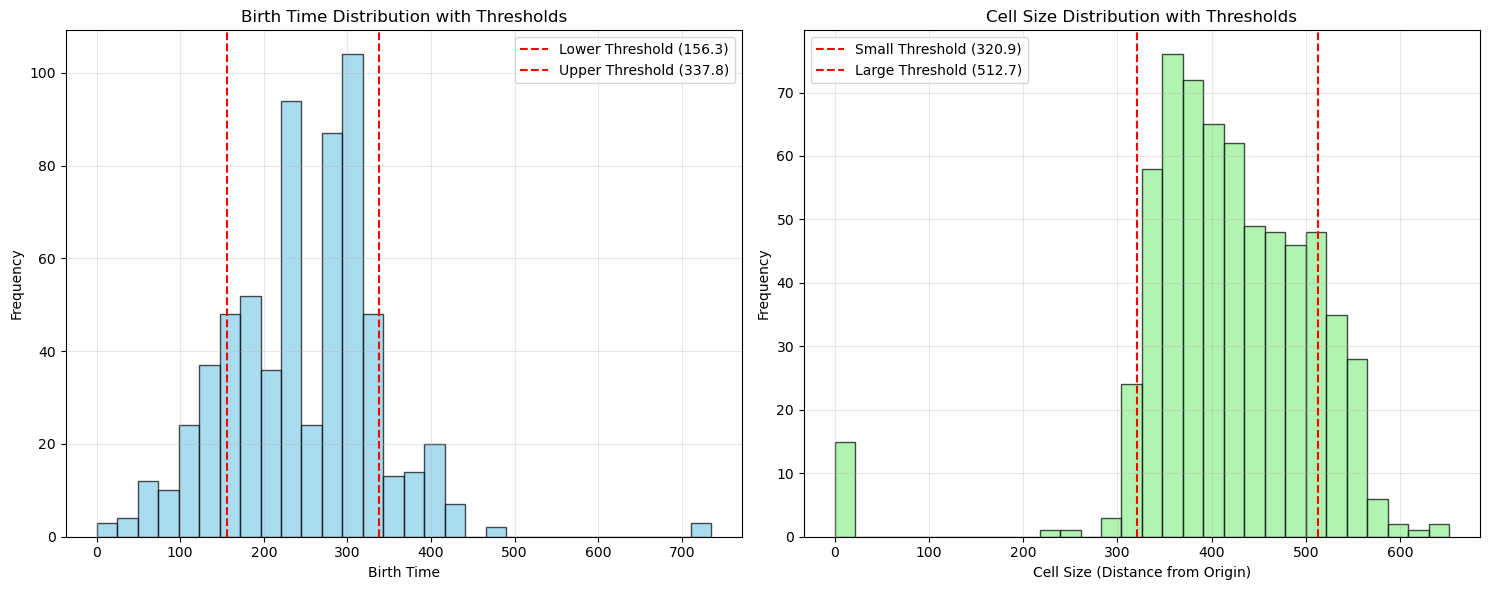

In [14]:
# Visualize threshold boundaries
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Birth Time distribution with thresholds
axes[0].hist(df['Birth Time'], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
axes[0].axvline(thresholds['birth_time_threshold_low'], color='red', linestyle='--', 
               label=f"Lower Threshold ({thresholds['birth_time_threshold_low']:.1f})")
axes[0].axvline(thresholds['birth_time_threshold_high'], color='red', linestyle='--',
               label=f"Upper Threshold ({thresholds['birth_time_threshold_high']:.1f})")
axes[0].set_xlabel('Birth Time')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Birth Time Distribution with Thresholds')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Cell Size distribution with thresholds
axes[1].hist(df['cell_size'], bins=30, alpha=0.7, color='lightgreen', edgecolor='black')
axes[1].axvline(thresholds['size_threshold_small'], color='red', linestyle='--',
               label=f"Small Threshold ({thresholds['size_threshold_small']:.1f})")
axes[1].axvline(thresholds['size_threshold_large'], color='red', linestyle='--',
               label=f"Large Threshold ({thresholds['size_threshold_large']:.1f})")
axes[1].set_xlabel('Cell Size (Distance from Origin)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Cell Size Distribution with Thresholds')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 6. Advanced Analysis and Correlations

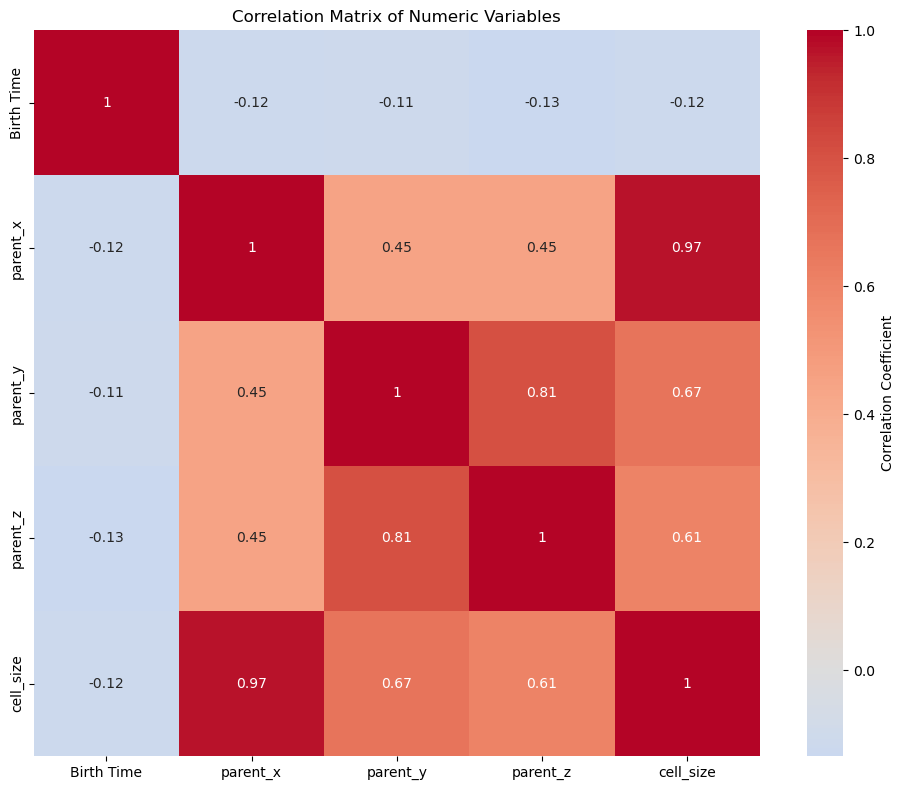

Strong correlations (|r| > 0.5):
  parent_x ↔ cell_size: 0.965
  parent_y ↔ parent_z: 0.805
  parent_y ↔ cell_size: 0.668
  parent_z ↔ cell_size: 0.610


In [15]:
# Create correlation matrix
numeric_cols = ['Birth Time', 'parent_x', 'parent_y', 'parent_z', 'cell_size']
available_cols = [col for col in numeric_cols if col in df.columns]

if len(available_cols) > 2:
    plt.figure(figsize=(10, 8))
    correlation_matrix = df[available_cols].corr()
    
    # Create heatmap
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
                square=True, cbar_kws={'label': 'Correlation Coefficient'})
    plt.title('Correlation Matrix of Numeric Variables')
    plt.tight_layout()
    plt.show()
    
    # Print strong correlations
    print("Strong correlations (|r| > 0.5):")
    for i, col1 in enumerate(available_cols):
        for j, col2 in enumerate(available_cols):
            if i < j:
                corr_val = correlation_matrix.loc[col1, col2]
                if abs(corr_val) > 0.5:
                    print(f"  {col1} ↔ {col2}: {corr_val:.3f}")

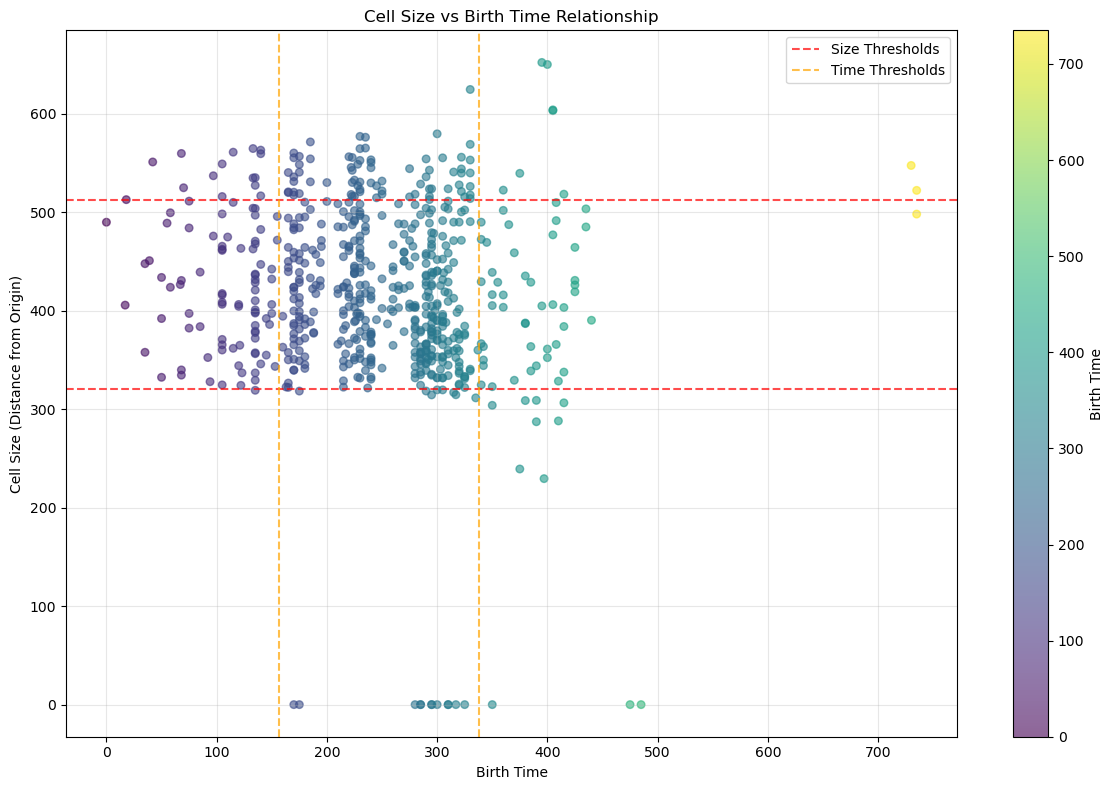

In [16]:
# Size vs Time analysis
plt.figure(figsize=(12, 8))

# Scatter plot with color coding
scatter = plt.scatter(df['Birth Time'], df['cell_size'], 
                     alpha=0.6, c=df['Birth Time'], cmap='viridis', s=30)
plt.colorbar(scatter, label='Birth Time')
plt.xlabel('Birth Time')
plt.ylabel('Cell Size (Distance from Origin)')
plt.title('Cell Size vs Birth Time Relationship')

# Add threshold lines
plt.axhline(thresholds['size_threshold_small'], color='red', linestyle='--', alpha=0.7, label='Size Thresholds')
plt.axhline(thresholds['size_threshold_large'], color='red', linestyle='--', alpha=0.7)
plt.axvline(thresholds['birth_time_threshold_low'], color='orange', linestyle='--', alpha=0.7, label='Time Thresholds')
plt.axvline(thresholds['birth_time_threshold_high'], color='orange', linestyle='--', alpha=0.7)

plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 7. Export Results and Data

In [17]:
# Create output directories
output_dirs = {
    'statistics': Path('../outputs/lineage_analysis/statistics'),
    'processed_data': Path('../data/processed_datasets'),
    'visualizations': Path('../outputs/lineage_analysis/visualizations')
}

for name, path in output_dirs.items():
    path.mkdir(parents=True, exist_ok=True)
    print(f"Created directory: {path}")

Created directory: ../outputs/lineage_analysis/statistics
Created directory: ../data/processed_datasets
Created directory: ../outputs/lineage_analysis/visualizations


In [18]:
# Generate comprehensive report
report_path = output_dirs['statistics'] / 'comprehensive_analysis_report.json'
comprehensive_report = generate_comprehensive_report(df, save_path=str(report_path))

print("\n📊 Comprehensive analysis report generated and saved.")

Generating comprehensive statistical analysis report...
✓ Basic statistics completed
✓ Temporal analysis completed
✓ Spatial analysis completed
✓ Lineage analysis completed
✓ Correlation analysis completed
Report saved to: ../outputs/lineage_analysis/statistics/comprehensive_analysis_report.json

📊 Comprehensive analysis report generated and saved.


In [19]:
# Export processed dataset with calculated features
df_processed = df.copy()

# Add threshold-based categories
df_processed['size_category'] = pd.cut(
    df_processed['cell_size'],
    bins=[0, thresholds['size_threshold_small'], thresholds['size_threshold_large'], np.inf],
    labels=['small', 'medium', 'large']
)

df_processed['time_category'] = pd.cut(
    df_processed['Birth Time'],
    bins=[0, thresholds['birth_time_threshold_low'], thresholds['birth_time_threshold_high'], np.inf],
    labels=['early', 'mid', 'late']
)

# Export processed data
processed_data_path = output_dirs['processed_data'] / 'processed_cell_data.csv'
df_processed.to_csv(processed_data_path, index=False)

print(f"\n💾 Processed dataset exported to: {processed_data_path}")
print(f"   Added columns: {list(set(df_processed.columns) - set(df.columns))}")


💾 Processed dataset exported to: ../data/processed_datasets/processed_cell_data.csv
   Added columns: ['size_category', 'time_category']


In [20]:
import json

# Export threshold values for use in other notebooks
threshold_path = output_dirs['processed_data'] / 'calculated_thresholds.json'

with open(threshold_path, 'w') as f:
    json.dump(thresholds, f, indent=2)
    
print(f"\n🎯 Thresholds exported to: {threshold_path}")
print("   These can be loaded in visualization notebooks for consistent categorization.")


🎯 Thresholds exported to: ../data/processed_datasets/calculated_thresholds.json
   These can be loaded in visualization notebooks for consistent categorization.


## 8. Summary and Next Steps

In [ ]:
print("\n" + "="*60)
print("ANALYSIS COMPLETE - SUMMARY")
print("="*60)

print("\n📊 Dataset Overview:")
print(f"   • Shape: {df.shape[0]} rows × {df.shape[1]} columns")
print(f"   • Unique parent cells: {df['Parent Cell'].nunique()}")
print(f"   • Unique daughter cells: {len(pd.concat([df['Daughter 1'], df['Daughter 2']]).dropna().unique())}")
print(f"   • Time range: {df['Birth Time'].min():.1f} - {df['Birth Time'].max():.1f}")

print("\n🎯 Calculated Thresholds:")
print(f"   • Size (small/medium): {thresholds['size_threshold_small']:.2f}")
print(f"   • Size (medium/large): {thresholds['size_threshold_large']:.2f}")
print(f"   • Time (early/mid): {thresholds['birth_time_threshold_low']:.2f}")
print(f"   • Time (mid/late): {thresholds['birth_time_threshold_high']:.2f}")

print("\n📁 Generated Outputs:")
for name, path in output_dirs.items():
    files = list(path.glob('*'))
    print(f"   • {name}: {len(files)} files in {path}")

print("\n➡️  Next Steps:")
print("   • Run 02_cell_lineage_visualization.ipynb for interactive plots")
print("   • Run 03_tgn_training.ipynb for machine learning analysis")
print("   • Run 04_connectome_development_analysis.ipynb for connectome studies")
print("   • Explore outputs/lineage_analysis/ directory for detailed results")

print("\n✅ Data analysis notebook completed successfully!")


ANALYSIS COMPLETE - SUMMARY

📊 Dataset Overview:
   • Shape: 642 rows × 8 columns
   • Unique parent cells: 629
   • Unique daughter cells: 1141
   • Time range: 0.0 - 735.0

🎯 Calculated Thresholds:
   • Size (small/medium): 320.88
   • Size (medium/large): 512.65
   • Time (early/mid): 156.32
   • Time (mid/late): 337.83

📁 Generated Outputs:
   • statistics: 9 files in ../outputs/lineage_analysis/statistics
   • processed_data: 8 files in ../data/processed_datasets
   • visualizations: 13 files in ../outputs/lineage_analysis/visualizations

➡️  Next Steps:
   • Run 02_cell_lineage_visualization.ipynb for interactive plots
   • Run 03_tgn_training.ipynb for machine learning analysis
   • Explore outputs/lineage_analysis/ directory for detailed results

✅ Data analysis notebook completed successfully!
